## Analiză de sentiment
AnalizaDeSentiment este un proiect care utilizează tehnici de preprocesare a textului și algoritmi de învățare automată pentru a analiza și a clasifica sentimentele exprimate în recenziile pentru restaurantele din SUA de pe platforma Yelp. Scopul proiectului este să ofere utilizatorilor o înțelegere mai profundă a feedback-ului și a percepției publicului despre diferite restaurante și servicii, folosind tehnici avansate de procesare a limbajului natural și modele de clasificare precum XGBoost. Prin analiza sentimentului, proiectul își propune să ofere insight-uri valoroase pentru utilizatorii interesați de evaluarea experiențelor din restaurante.


### Importarea librăriilor

In [ ]:
!pip install contractions

In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import contractions
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load('en_core_web_sm')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Citirea datelor

In [ ]:
url = 'https://github.com/berinde/curs-analiza-datelor-complexe/blob/main/data/input/set_date_examen1.csv?raw=True'
reviews = pd.read_csv(url)
reviews.head(6)

,rest_id,text,rating
0,L772e6l2Yd0DJEyCBxBNng,Everytime I'm in town I hit this place for cur...,5.0
1,L772e6l2Yd0DJEyCBxBNng,I go to State Street Brats every time I am in ...,4.0
2,L772e6l2Yd0DJEyCBxBNng,Two of us visited on a Thursday lunch.\n\nThe ...,3.0
3,L772e6l2Yd0DJEyCBxBNng,State street brats has a dress code that openl...,1.0
4,L772e6l2Yd0DJEyCBxBNng,Sad to have a place like this on campus in Mad...,1.0
5,L772e6l2Yd0DJEyCBxBNng,The waffles fries are great! Traditional Wisco...,3.0


### Curățarea datelor

In [ ]:
# Informații despre recenzii
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11344 entries, 0 to 11343
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   rest_id  11344 non-null  object 
 1   text     11344 non-null  object 
 2   rating   11344 non-null  float64
dtypes: float64(1), object(2)
memory usage: 266.0+ KB


In [ ]:
# Numărul de recenzii pt fiecare rating
reviews['rating'].value_counts()

5.0    4618
4.0    3138
3.0    1407
1.0    1156
2.0    1025
Name: rating, dtype: int64

In [ ]:
# Numărul total de recenzii
total_reviews = reviews.shape[0]
print("Numărul total de recenzii:", total_reviews)

Numărul total de recenzii: 11344


In [ ]:
# Convertirea recenziilor din tip float în tip integer
reviews['rating'] = reviews['rating'].astype(int)

#### Din cauza faptului că ratingul 3 poate fi considerat neutru și poate conține opinii ambiguu exprimate sau echilibrate, care nu sunt foarte utile pentru clasificarea în sentimente pozitive sau negative, am hotărât să îl elimin. Prin eliminarea acestor ratinguri, pot simplifica problema la două clase principale: pozitive și negative.

In [ ]:
# Eliminarea recenziilor cu rating 3
reviews = reviews[reviews['rating']!=3].reset_index(drop=True)

# Verificarea distribuției ratingurilor actualizată
print("Distribuția ratingurilor după eliminarea ratingului 3:")
print(reviews['rating'].value_counts())

Distribuția ratingurilor după eliminarea ratingului 3:
5    4618
4    3138
1    1156
2    1025
Name: rating, dtype: int64


In [ ]:
# Numărul total de recenzii după eliminarea ratingului 3
total_reviews_after_removal = reviews.shape[0]
print("Numărul total de recenzii după eliminarea ratingului 3:", total_reviews_after_removal)

Numărul total de recenzii după eliminarea ratingului 3: 9937


### Adaug o nouă coloană care să clasifice ratingul in negativ (0) si pozitiv (1)

In [ ]:
# Crearea unei coloane noi 'positive' în funcție de ratinguri
reviews['positive'] = np.where(reviews['rating'] < 3, 0, 1)

# Verificarea distribuției noii coloane
print('Numărul de recenzii pozitive', len(reviews[reviews['positive']==1]))
print('Numărul de recenzii negative', len(reviews[reviews['positive']==0]))

Numărul de recenzii pozitive 7756
Numărul de recenzii negative 2181


### Procesarea textului

In [ ]:
recenzie_test = reviews['text'].iloc[0]
recenzie_test

"Everytime I'm in town I hit this place for curds, beer and brats. I spent a whole Sunday watching football here and had a blast. Crowded times are a little annoying, but it is a college place. Love the mustard selections too. Curds are a must!"

In [ ]:
reviews.head()

,rest_id,text,rating,positive
0,L772e6l2Yd0DJEyCBxBNng,Everytime I'm in town I hit this place for cur...,5,1
1,L772e6l2Yd0DJEyCBxBNng,I go to State Street Brats every time I am in ...,4,1
2,L772e6l2Yd0DJEyCBxBNng,State street brats has a dress code that openl...,1,0
3,L772e6l2Yd0DJEyCBxBNng,Sad to have a place like this on campus in Mad...,1,0
4,L772e6l2Yd0DJEyCBxBNng,Place was busy when we got there but the servi...,5,1


In [ ]:
def preprocesare_text(document):
    # Convertesc textul în text scris cu literă mică
    document = document.lower()
    # Înlocuiesc formele scurte (contractions)
    document = contractions.fix(document)
    # Regex
    # ^ = NOT
    document = re.sub(r'[^\w\s]', ' ', document)
    document = re.sub(r'[^a-z ]', '', document)
    # Împart documentul în cuvinte (tokenization)
    document = word_tokenize(document)
    # Înlătur cuvintele comune (stopwords)
    cuv_comune = stopwords.words('english')
    document = [element for element in document if element not in cuv_comune]
    # Convertesc din lista de cuvinte în string
    document = " ".join(document)
    # Reduc cuvântul la lema sa (Lemmatization)
    document = " ".join([word.lemma_ for word in nlp(document)])

    return document

In [ ]:
print('Recenzia Initiala:', recenzie_test)
print('')
print('Recenzia Procesata:', preprocesare_text(recenzie_test))

Recenzia Initiala: Everytime I'm in town I hit this place for curds, beer and brats. I spent a whole Sunday watching football here and had a blast. Crowded times are a little annoying, but it is a college place. Love the mustard selections too. Curds are a must!

Recenzia Procesata: everytime town hit place curds beer brat spend whole sunday watch football blast crowded time little annoying college place love mustard selection curd must


In [ ]:
reviews.head(6)

,rest_id,text,rating,positive
0,L772e6l2Yd0DJEyCBxBNng,Everytime I'm in town I hit this place for cur...,5,1
1,L772e6l2Yd0DJEyCBxBNng,I go to State Street Brats every time I am in ...,4,1
2,L772e6l2Yd0DJEyCBxBNng,State street brats has a dress code that openl...,1,0
3,L772e6l2Yd0DJEyCBxBNng,Sad to have a place like this on campus in Mad...,1,0
4,L772e6l2Yd0DJEyCBxBNng,Place was busy when we got there but the servi...,5,1
5,L772e6l2Yd0DJEyCBxBNng,"Dress code is noticeably racist, specifically ...",1,0


In [ ]:
reviews['text_prep'] = reviews['text'].apply(preprocesare_text)
reviews.head(6)

,rest_id,text,rating,positive,text_prep
0,L772e6l2Yd0DJEyCBxBNng,Everytime I'm in town I hit this place for cur...,5,1,everytime town hit place curds beer brat spend...
1,L772e6l2Yd0DJEyCBxBNng,I go to State Street Brats every time I am in ...,4,1,go state street brat every time wisconsin time...
2,L772e6l2Yd0DJEyCBxBNng,State street brats has a dress code that openl...,1,0,state street brat dress code openly discrimina...
3,L772e6l2Yd0DJEyCBxBNng,Sad to have a place like this on campus in Mad...,1,0,sad place like campus madison racist protocol ...
4,L772e6l2Yd0DJEyCBxBNng,Place was busy when we got there but the servi...,5,1,place busy get service good cashier suggest gr...
5,L772e6l2Yd0DJEyCBxBNng,"Dress code is noticeably racist, specifically ...",1,0,dress code noticeably racist specifically targ...


### Verific dacă am făcut corect partea de procesare a datelor

In [ ]:
# Vizualizarea datelor preprocesate
print("Recenzia originală:", recenzie_test)
print("Recenzia preprocesată:", reviews['text_prep'].iloc[0])

# Verificarea dimensiunii datelor
print("Dimensiunea datelor inițiale:", reviews.shape)
print("Dimensiunea datelor după preprocesare:", reviews.shape)

# Verificarea tokenizării
print("Tokenizare pentru prima recenzie:", nltk.word_tokenize(recenzie_test))
print("Tokenizare pentru prima recenzie preprocesată:", reviews['text_prep'].iloc[0].split())

# Verificarea lematizării
print("Lematizarea pentru prima recenzie preprocesată:", reviews['text_prep'].iloc[0])

Recenzia originală: Everytime I'm in town I hit this place for curds, beer and brats. I spent a whole Sunday watching football here and had a blast. Crowded times are a little annoying, but it is a college place. Love the mustard selections too. Curds are a must!
Recenzia preprocesată: everytime town hit place curds beer brat spend whole sunday watch football blast crowded time little annoying college place love mustard selection curd must
Dimensiunea datelor inițiale: (9937, 5)
Dimensiunea datelor după preprocesare: (9937, 5)
Tokenizare pentru prima recenzie: ['Everytime', 'I', "'m", 'in', 'town', 'I', 'hit', 'this', 'place', 'for', 'curds', ',', 'beer', 'and', 'brats', '.', 'I', 'spent', 'a', 'whole', 'Sunday', 'watching', 'football', 'here', 'and', 'had', 'a', 'blast', '.', 'Crowded', 'times', 'are', 'a', 'little', 'annoying', ',', 'but', 'it', 'is', 'a', 'college', 'place', '.', 'Love', 'the', 'mustard', 'selections', 'too', '.', 'Curds', 'are', 'a', 'must', '!']
Tokenizare pentru 

### I. Bag-of-Words (BOW) și antrenarea unui model XGBoost

#### Divizarea datelor în setul de antrenare și setul de testare

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    reviews['text_prep'],
    reviews['positive'],
    test_size=0.2,
    random_state=42
)

#### Construirea matricei Bag-of-Words (BWW)

In [ ]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

#### Antrenarea modelului XGBoost

In [ ]:
model = XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    verbosity=3,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=8,
    max_leaves=32,
    subsample=0.95,
    eval_metric='auc'
)

In [ ]:
model.fit(X_train_bow, y_train, eval_set=[(X_test_bow, y_test)])

[18:14:21] ======== Monitor (0): HostSketchContainer ========
[18:14:21] AllReduce: 0.004197s, 1 calls @ 4197us

[18:14:21] MakeCuts: 0.007428s, 1 calls @ 7428us

[18:14:21] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-auc:0.78915
[1]	validation_0-auc:0.80206
[2]	validation_0-auc:0.83452
[3]	validation_0-auc:0.85146
[4]	validation_0-auc:0.86511
[5]	validation_0-auc:0.87592
[6]	validation_0-auc:0.88180
[7]	validation_0-auc:0.89113
[8]	validation_0-auc:0.89729
[9]	validation_0-auc:0.89967
[10]	validation_0-auc:0.90397
[11]	validation_0-auc:0.90633
[12]	validation_0-auc:0.91198
[13]	validation_0-auc:0.91624
[14]	validation_0-auc:0.91878
[15]	validation_0-auc:0.92137
[16]	validation_0-auc:0.92372
[17]	validation_0-auc:0.92633
[18]	validation_0-auc:0.92687
[19]	validation_0-auc:0.92810
[20]	validation_0-auc:0.92964
[21]	validation_0-auc:0.93242
[22]	validation_0-auc:0.93389
[23]	validation_0-auc:0.93536
[24]	validation_0-auc:0.93706
[25]	validation_0-auc:0.

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=32,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Predicția pe setul de testare

In [ ]:
y_test_bow_preds = model.predict(X_test_bow)

[18:15:49] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


### Afișarea matricei de confuzie pentru modelul BOW cu XGBoost

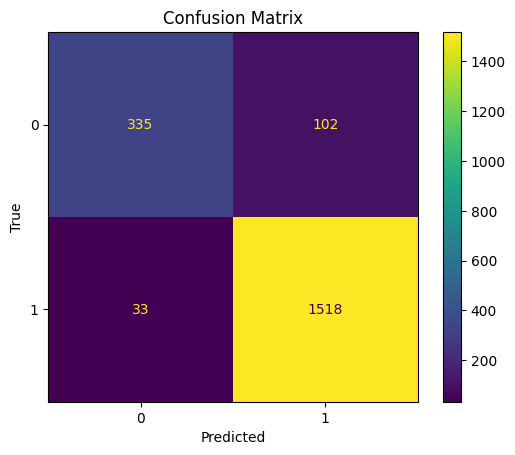

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(model, X_test_bow, y_test, labels=[0, 1])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Curba ROC pentru modelul BOW cu XGBoost

#### Pentru a genera curba ROC calculez probabilitățile aferente claselor, ratele de adevărat pozitiv și fals pozitiv pentru curba ROC, apoi calculez aria de sub curbă

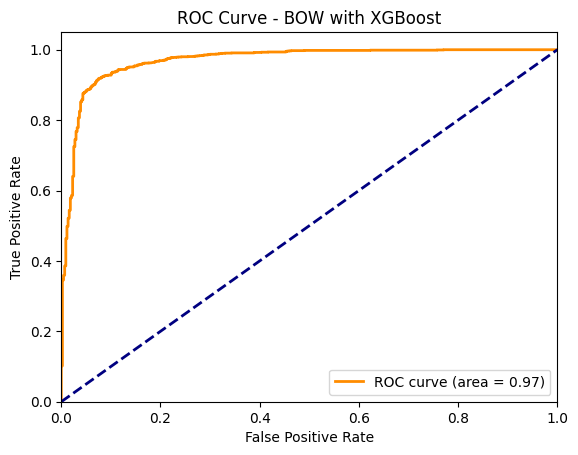

In [ ]:
# Calcularea probabilităților de clasificare pentru clasa pozitivă
y_prob_bow = model.predict_proba(X_test_bow)[:, 1]

# Calcularea ratelelor de TPR și FPR
fpr_bow, tpr_bow, _ = roc_curve(y_test, y_prob_bow)

# Calcularea AUC (Area Under Curve)
roc_auc_bow = auc(fpr_bow, tpr_bow)

# Trasarea curbei ROC
plt.figure()
plt.plot(fpr_bow, tpr_bow, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_bow)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BOW with XGBoost')
plt.legend(loc="lower right")
plt.show()

#### Classification Report

In [ ]:
print('Classification Report pe setul de test\n',
      classification_report(y_test, y_test_bow_preds)
)

Classification Report pe setul de test
               precision    recall  f1-score   support

           0       0.91      0.77      0.83       437
           1       0.94      0.98      0.96      1551

    accuracy                           0.93      1988
   macro avg       0.92      0.87      0.89      1988
weighted avg       0.93      0.93      0.93      1988



### II. Word2Vec și antrenarea unui model XGBoost

#### Antrenarea modelului Word2Vec

In [ ]:
sentences = [review.split() for review in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

#### Reprezentarea textului cu vectorii Word2Vec

In [ ]:
def text_to_vector(text):
    tokens = text.split()
    vector = np.zeros(word2vec_model.vector_size)
    for token in tokens:
        if token in word2vec_model.wv.key_to_index:
            vector += word2vec_model.wv[token]
    return vector

X_train_vec = np.vstack(X_train.apply(text_to_vector))
X_test_vec = np.vstack(X_test.apply(text_to_vector))

#### Antrenarea modelului XGBoost

In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Afișarea matricei de confuzie pentru modelul Word2Vec cu XGBoost


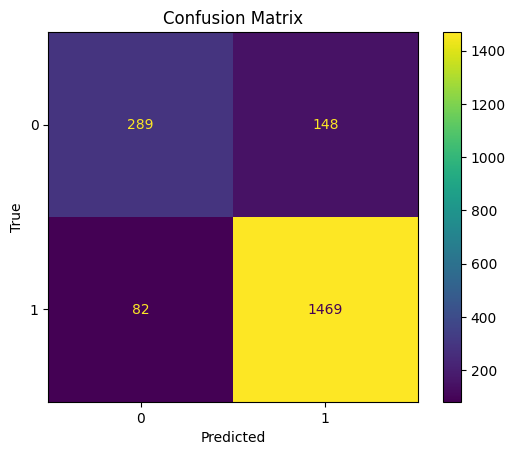

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_vec, y_test, labels=[0, 1])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Curba ROC pentru modelul Word2Vec cu XGBoost

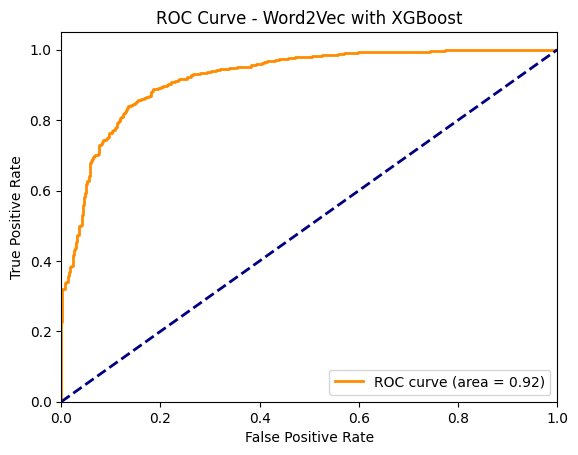

In [ ]:
# Calcularea probabilităților de clasificare pentru clasa pozitivă
y_prob_w2v = xgb_model.predict_proba(X_test_vec)[:, 1]

# Calcularea ratelelor de TPR și FPR
fpr_w2v, tpr_w2v, _ = roc_curve(y_test, y_prob_w2v)

# Calcularea AUC (Area Under Curve)
roc_auc_w2v = auc(fpr_w2v, tpr_w2v)

# Trasarea curbei ROC
plt.figure()
plt.plot(fpr_w2v, tpr_w2v, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_w2v)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Word2Vec with XGBoost')
plt.legend(loc="lower right")
plt.show()

#### Classification Report

In [ ]:
y_pred = xgb_model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.66      0.72       437
           1       0.91      0.95      0.93      1551

    accuracy                           0.88      1988
   macro avg       0.84      0.80      0.82      1988
weighted avg       0.88      0.88      0.88      1988



# Interpretarea rezultatelor și compararea modelelor

In [ ]:
# Raportul de clasificare pentru modelul BOW cu XGBoost
print("Raportul de clasificare pentru modelul BOW cu XGBoost:")
print(classification_report(y_test, y_test_bow_preds))

# Raportul de clasificare pentru modelul Word2Vec cu XGBoost
print("\nRaportul de clasificare pentru modelul Word2Vec cu XGBoost:")
print(classification_report(y_test, y_pred))

Raportul de clasificare pentru modelul BOW cu XGBoost:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       437
           1       0.94      0.98      0.96      1551

    accuracy                           0.93      1988
   macro avg       0.92      0.87      0.89      1988
weighted avg       0.93      0.93      0.93      1988


Raportul de clasificare pentru modelul Word2Vec cu XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       437
           1       0.91      0.95      0.93      1551

    accuracy                           0.88      1988
   macro avg       0.84      0.80      0.82      1988
weighted avg       0.88      0.88      0.88      1988



## Modelul BOW cu XGBoost:
Precision: reprezintă rata la care modelele identifică corect exemplele pozitive din totalul predicțiilor. Astfel, pentru clasa 0 (recenziile negative), precizia este 0.91, ceea ce înseamnă că 91% din recenziile identificate ca negative sunt corecte. Pentru clasa 1 (recenziile pozitive), precizia este 0.94, indicând că 94% din recenziile identificate ca pozitive sunt corecte.

Recall: Exprimă rata la care modelele identifică corect exemplele pozitive din totalul exemplelor reale pozitive. Pentru clasa 0, recall-ul este 0.77, ceea ce înseamnă că 77% din recenziile reale negative au fost identificate corect. Pentru clasa 1, recall-ul este 0.98, indicând că 98% din recenziile reale pozitive au fost identificate corect.

F1-score: Este o măsură care combină precizia și recall-ul într-o singură metrică. Pentru clasa 0, scorul F1 este 0.83, iar pentru clasa 1, scorul F1 este 0.96.

Suport: Reprezintă numărul total de exemple din setul de testare pentru fiecare clasă. Astfel, 1551 de exemple aparțin clasei pozitive, iar 437 de exemple aparțin clasei negative.

Accuracy: Pentru modelul BOW cu XGBoost, acuratețea este de 93%, ceea ce indică o performanță bună în ceea ce privește clasificarea recenziilor și rating-urilor pozitive și negative ale restaurantelor din SUA. Astfel, modelul nostru a clasificat corect aproximativ 93% din totalul recenziilor.

## Modelul Word2Vec cu XGBoost:
Precision: Pentru clasa 0 (recenziile negative), precizia este de 0.78. Acest lucru înseamnă că 78% din recenziile identificate ca negative au fost clasificate corect de model.Pentru clasa 1 (recenziile pozitive), precizia este de 0.90. Acest lucru înseamnă că 90% din recenziile identificate ca pozitive au fost clasificate corect de model.

Recall: Pentru clasa 0, recall-ul este de 0.64. Acest lucru înseamnă că 64% din recenziile reale negative au fost identificate corect de model. Pentru clasa 1, recall-ul este de 0.95. Acest lucru înseamnă că 95% din recenziile reale pozitive au fost identificate corect de model.

F1-score: Pentru clasa 0, scorul F1 este de 0.70.
Pentru clasa 1, scorul F1 este de 0.93. Acest scor reflectă o performanță bună a modelului în identificarea recenziilor pozitive.

Acuratețea: Acuratețea globală a modelului este de 0.88, ceea ce înseamnă că 88% din totalul recenziilor au fost clasificate corect de model.



### Concluzia
Modelul BOW cu XGBoost are o acuratețe globală mai mare (0.93) în comparație cu modelul Word2Vec cu XGBoost (0.88). Acest lucru indică faptul că modelul BOW are o capacitate mai mare de a clasifica corect recenziile în general și un scor F1 mai ridicat pentru identificarea recenziilor negative (0.83) în comparație cu modelul Word2Vec cu XGBoost (0.72). Acest lucru sugerează că modelul BOW este mai eficient în identificarea recenziilor negative, ceea ce ar putea fi crucial în contextul industriei serviciilor alimentare, unde feedback-ul negativ poate influența deciziile de afaceri. Mai mult decât atât, performanța globală este mai echilibrată: modelul BOW cu XGBoost obține scoruri F1 ridicate pentru ambele clase (0.83 pentru clasa 0 și 0.96 pentru clasa 1), indicând o performanță echilibrată în identificarea atât a recenziilor negative, cât și a celor pozitive.


În concluzie, modelul BOW cu XGBoost pare să ofere o performanță mai robustă și mai consistentă în identificarea și clasificarea recenziilor pentru restaurantele din SUA și este semnificativ în contextul industriei serviciilor alimentare din SUA, evidențiind utilitatea acestui model în înțelegerea și evaluarea experiențelor clienților în restaurante. Prin identificarea corectă a calității serviciilor și a experiențelor oferite de restaurante, acest model poate contribui la îmbunătățirea standardelor de calitate și la satisfacția clienților.